# Vertebral Column Classification

Binary classification project to predict vertebral column abnormalities using K-Nearest Neighbors (KNN) algorithm with various distance metrics.

## 1. Data Loading and Preprocessing

### Package Imports

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os

### Load the Vertebral Column Dataset

In [ ]:
col_names = [
    'pelvic_incidence',
    'pelvic_tilt',
    'lumbar_lordosis_angle',
    'sacral_slope',
    'pelvic_radius',
    'grade_of_spondylolisthesis',
    'class'
]

df = pd.read_csv('../data/vertebral_column_data/column_2C.dat',
                 delim_whitespace=True, header=None, names=col_names)

# Map 'NO' (Normal) to 0 and 'AB' (Abnormal) to 1
df['class'] = df['class'].map({'NO': 0, 'AB': 1})

print(df.head())
print(f"\nDataset shape: {df.shape}")
print(f"Class distribution:\n{df['class'].value_counts()}")

   pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
0             63.03        22.55                  39.61         40.48   
1             39.06        10.06                  25.02         29.00   
2             68.83        22.22                  50.09         46.61   
3             69.30        24.65                  44.31         44.64   
4             49.71         9.65                  28.32         40.06   

   pelvic_radius  grade_of_spondylolisthesis  class  
0          98.67                       -0.25      1  
1         114.41                        4.56      1  
2         105.99                       -3.53      1  
3         101.87                       11.21      1  
4         108.17                        7.92      1  


## 2. Exploratory Data Analysis

### Pairwise Scatterplots

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

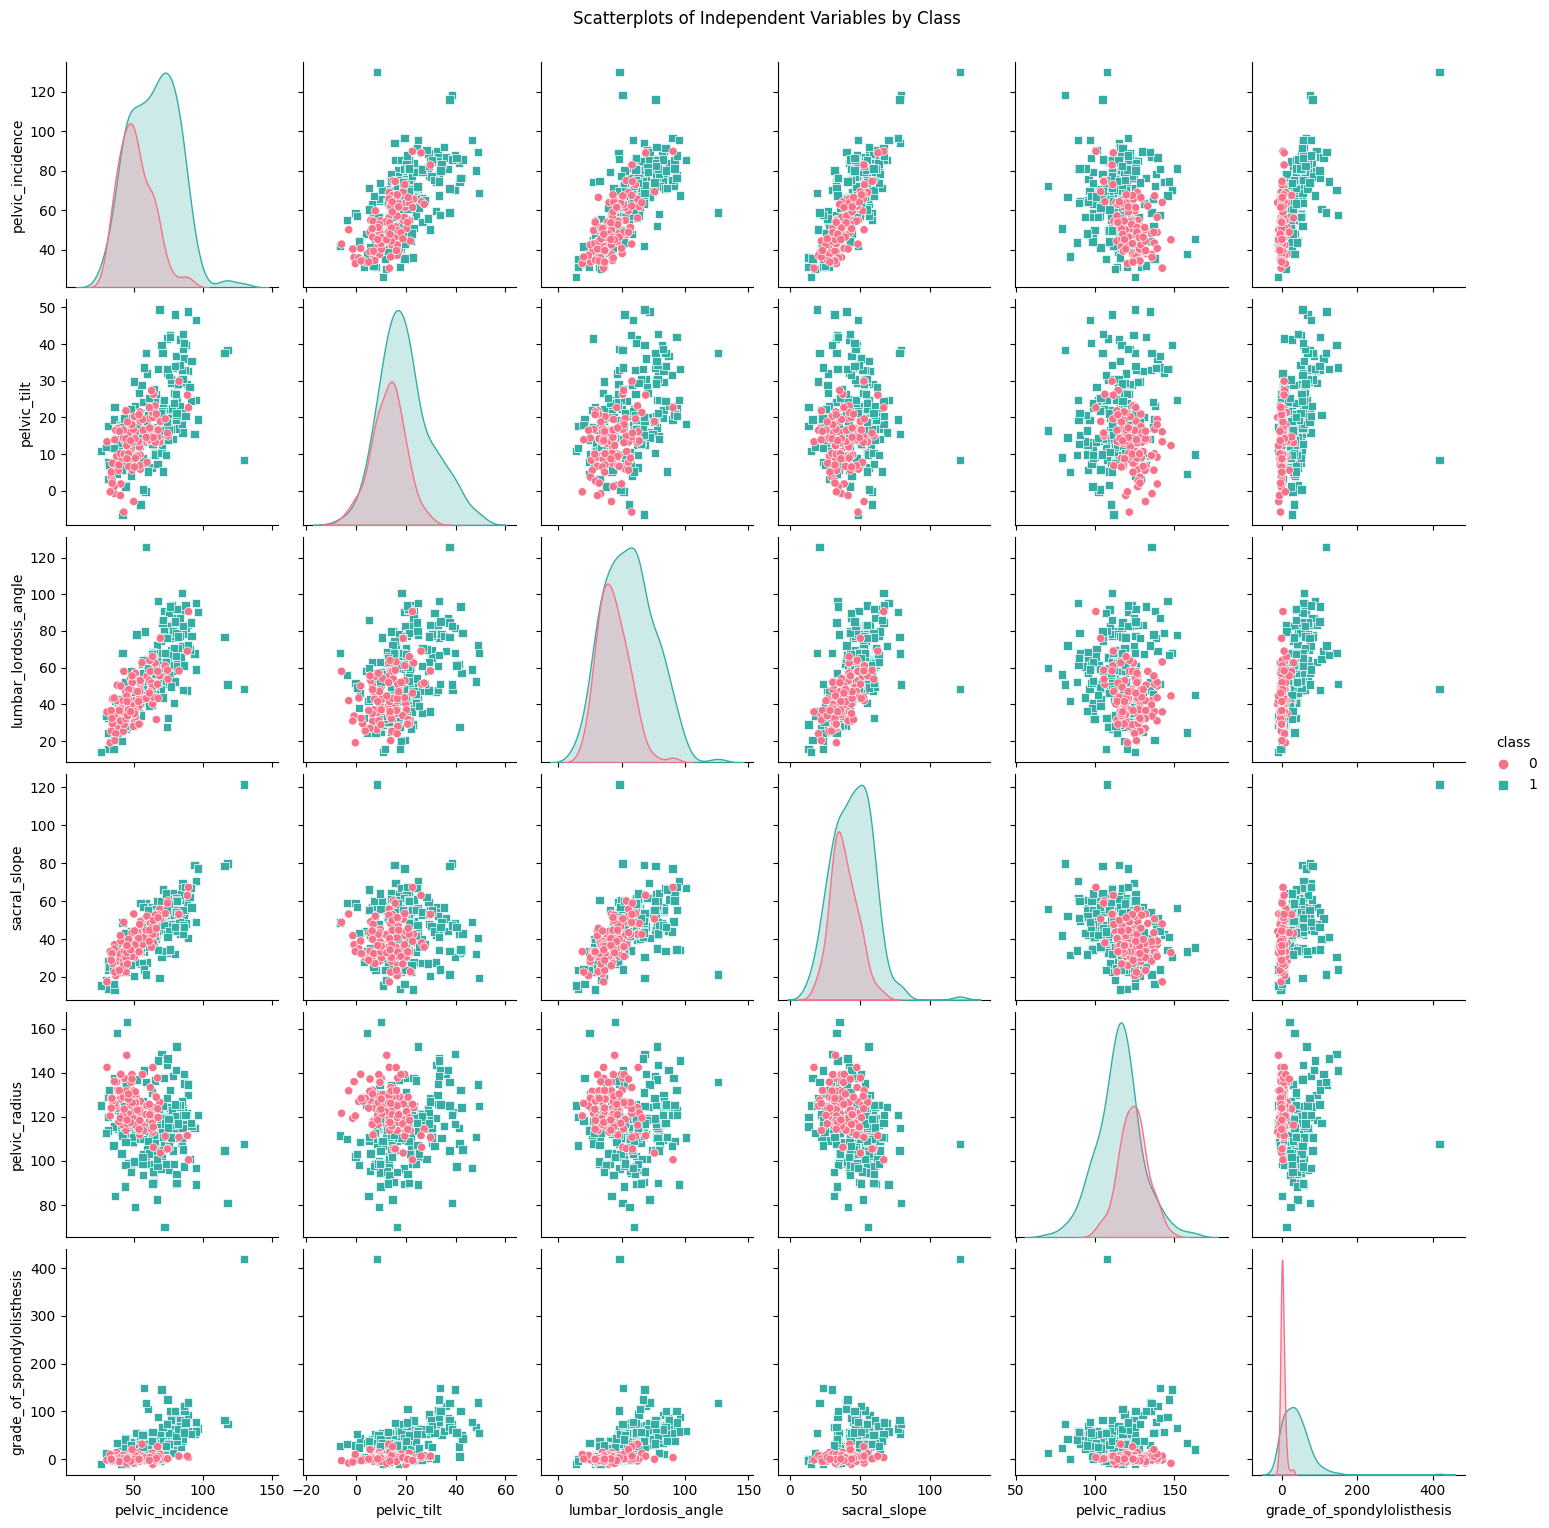

In [ ]:
sns.pairplot(df, hue='class', markers=["o", "s"], palette='husl')
plt.suptitle('Scatterplots of Independent Variables by Class', y=1.02)
plt.tight_layout()
plt.savefig('../results/pairplot.png', dpi=300, bbox_inches='tight')
plt.show()

### Boxplots by Class

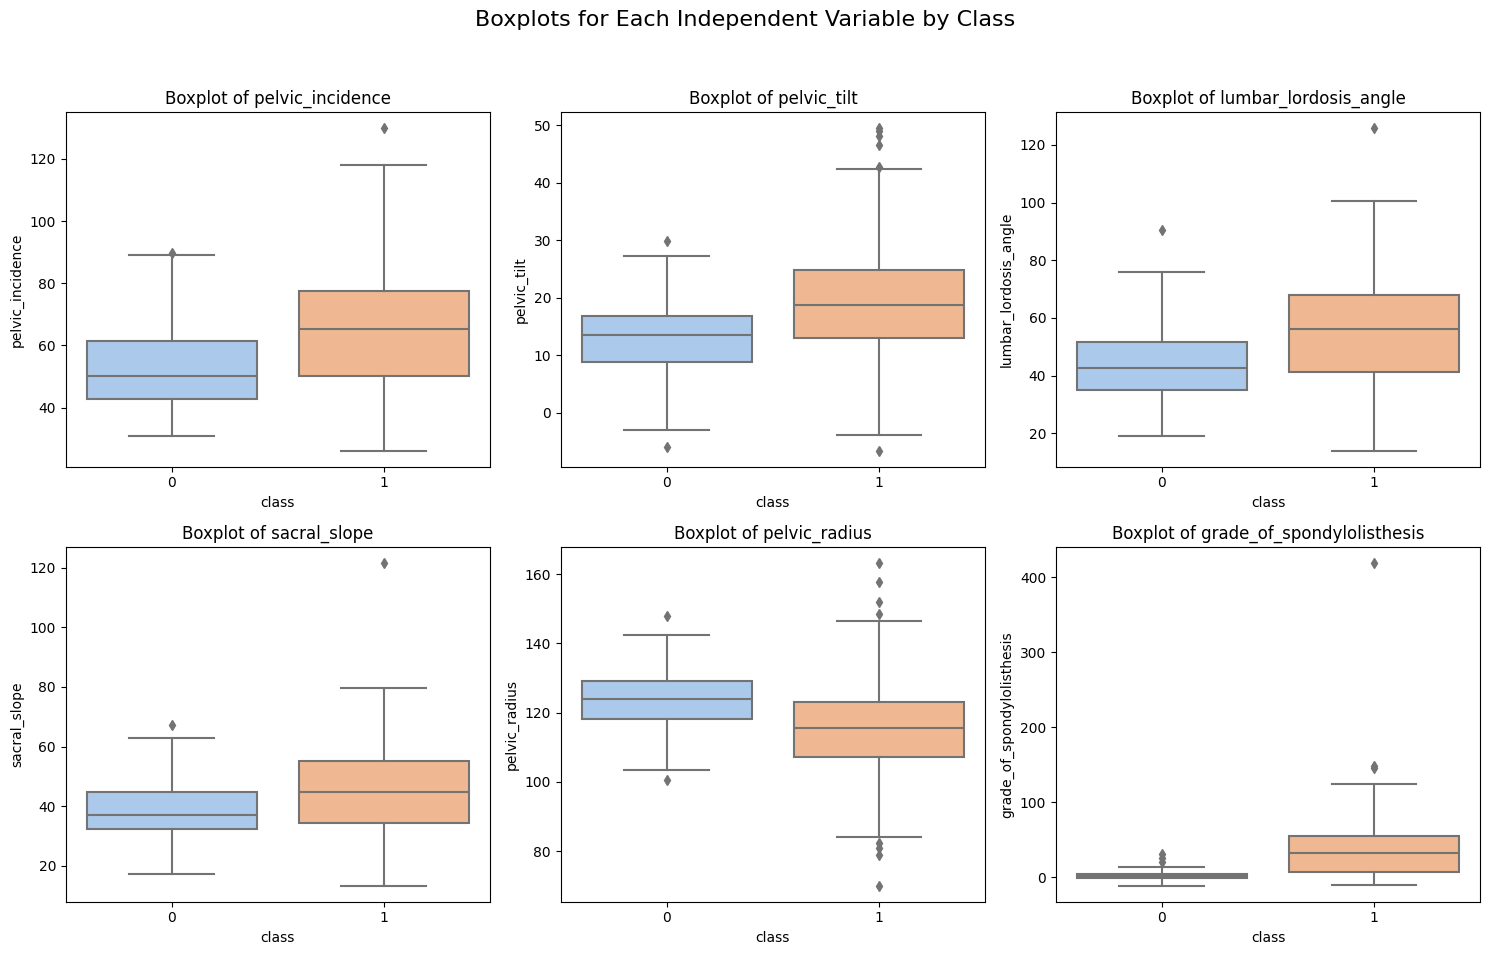

In [ ]:
plt.figure(figsize=(15, 10))
plt.suptitle('Boxplots for Each Independent Variable by Class', fontsize=16)
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='class', y=col, data=df, palette='pastel')
    plt.title(f'Boxplot of {col}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../results/boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

### Train-Test Split

In [ ]:
class_0_df = df[df['class'] == 0]
class_1_df = df[df['class'] == 1]

train_df = pd.concat([class_0_df.iloc[:70], class_1_df.iloc[:140]])
test_df = pd.concat([class_0_df.iloc[70:], class_1_df.iloc[140:]])

X_train = train_df.drop('class', axis=1).to_numpy()
y_train = train_df['class'].to_numpy()
X_test = test_df.drop('class', axis=1).to_numpy()
y_test = test_df['class'].to_numpy()

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


## 3. K-Nearest Neighbors Implementation

### Core KNN Functions

In [ ]:
def euclidean_distance(row1, row2):
    """Calculate Euclidean distance between two vectors."""
    return np.sqrt(np.sum((row1 - row2)**2))

def get_neighbors(X_train, y_train, test_row, k, distance_func):
    """Find k most similar neighbors for a test instance."""
    distances = []
    for i, train_row in enumerate(X_train):
        dist = distance_func(test_row, train_row)
        distances.append((train_row, y_train[i], dist))
    # Sort by distance
    distances.sort(key=lambda tup: tup[2])
    
    # Return the top k neighbors (instance, class, and distance)
    return distances[:k]

def predict_classification(neighbors):
    """Make prediction based on majority vote of neighbors."""
    outputs = [row[1] for row in neighbors]
    prediction = Counter(outputs).most_common(1)[0][0]
    return prediction

def knn(X_train, y_train, X_test, k, distance_func=euclidean_distance):
    """K-Nearest Neighbors classifier.
    
    Parameters:
    -----------
    X_train : array-like
        Training feature matrix
    y_train : array-like
        Training labels
    X_test : array-like
        Test feature matrix
    k : int
        Number of neighbors
    distance_func : function
        Distance metric function
    
    Returns:
    --------
    predictions : array
        Predicted class labels
    """
    predictions = []
    for test_row in X_test:
        neighbors = get_neighbors(X_train, y_train, test_row, k, distance_func)
        output = predict_classification(neighbors)
        predictions.append(output)
    return np.array(predictions)

### Model Evaluation with Euclidean Distance

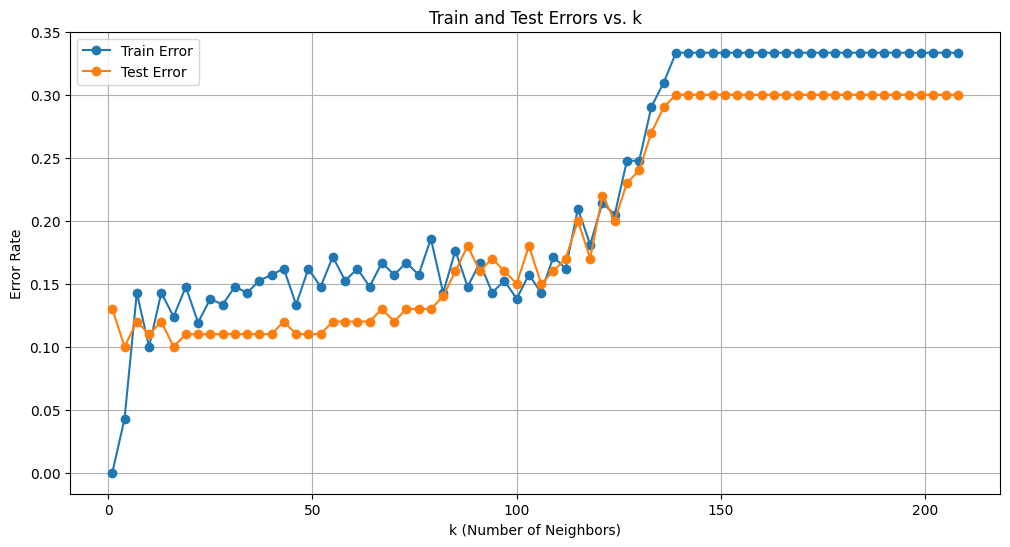

The best k* is 16 with a minimum test error of 0.1000

Performance Metrics for k* = 16
Confusion Matrix:
 [[20 10]
 [ 0 70]]
True Positive Rate (TPR): 1.0000
True Negative Rate (TNR): 0.6667
Precision: 0.8750
F1-Score: 0.9333


In [ ]:
k_values = [k for k in range(208, 0, -3)]
if 1 not in k_values:
    k_values.append(1)

train_errors = []
test_errors = []

for k in k_values:
    # Calculate training error
    y_train_pred = knn(X_train, y_train, X_train, k, euclidean_distance)
    train_errors.append(1 - np.mean(y_train_pred == y_train))
    
    # Calculate test error
    y_test_pred = knn(X_train, y_train, X_test, k, euclidean_distance)
    test_errors.append(1 - np.mean(y_test_pred == y_test))

plt.figure(figsize=(12, 6))
plt.plot(k_values, train_errors, label='Train Error', marker='o')
plt.plot(k_values, test_errors, label='Test Error', marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Error Rate')
plt.title('Train and Test Errors vs. k (Euclidean Distance)')
plt.legend()
plt.grid(True)
plt.savefig('../results/error_curve_euclidean.png', dpi=300, bbox_inches='tight')
plt.show()

min_test_error_val = min(test_errors)
best_k_index = np.argmin(test_errors)
best_k = k_values[best_k_index]

print(f"Best k*: {best_k} with minimum test error: {min_test_error_val:.4f}")

# Get predictions for best k
y_pred_best = knn(X_train, y_train, X_test, best_k, euclidean_distance)

# Calculate performance metrics
tp = np.sum((y_pred_best == 1) & (y_test == 1))
tn = np.sum((y_pred_best == 0) & (y_test == 0))
fp = np.sum((y_pred_best == 1) & (y_test == 0))
fn = np.sum((y_pred_best == 0) & (y_test == 1))

cm = np.array([[tn, fp], [fn, tp]])
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
precision = tp / (tp + fp)
f1 = 2 * (precision * tpr) / (precision + tpr)

print("\nPerformance Metrics for k* =", best_k)
print("Confusion Matrix:")
print(cm)
print(f"True Positive Rate (TPR/Recall): {tpr:.4f}")
print(f"True Negative Rate (TNR/Specificity): {tnr:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")

### Learning Curve Analysis

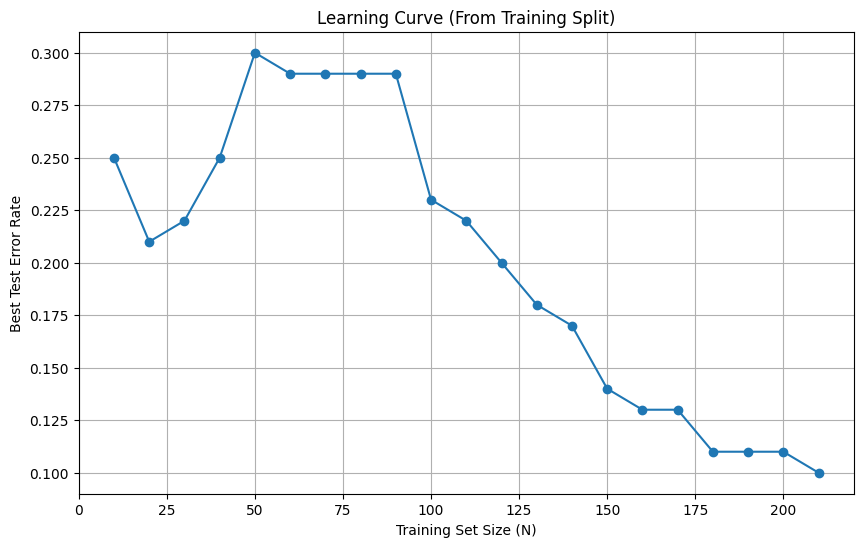

In [ ]:
train_class0 = train_df[train_df['class'] == 0].drop('class', axis=1).to_numpy()
train_class1 = train_df[train_df['class'] == 1].drop('class', axis=1).to_numpy()
train_y0 = train_df[train_df['class'] == 0]['class'].to_numpy()
train_y1 = train_df[train_df['class'] == 1]['class'].to_numpy()

N_values = range(10, 211, 10)
best_test_errors_n = []

for N in N_values:
    n0 = N // 3
    n1 = N - n0

    X_train_n = np.vstack([train_class0[:n0], train_class1[:n1]])
    y_train_n = np.hstack([train_y0[:n0], train_y1[:n1]])

    k_range_n = range(1, N, 5)
    errs = []
    for k in k_range_n:
        y_pred = knn(X_train_n, y_train_n, X_test, k, euclidean_distance)
        errs.append(1 - np.mean(y_pred == y_test))
    best_test_errors_n.append(min(errs))

plt.figure(figsize=(10,6))
plt.plot(N_values, best_test_errors_n, marker='o')
plt.xlabel('Training Set Size (N)')
plt.ylabel('Best Test Error Rate')
plt.title('Learning Curve')
plt.grid(True)
plt.savefig('../results/learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Alternative Distance Metrics

In [ ]:
def minkowski_distance(row1, row2, p):
    """Calculate Minkowski distance with parameter p."""
    return np.sum(np.abs(row1 - row2)**p)**(1/p)

def manhattan_distance(row1, row2):
    """Calculate Manhattan distance (Minkowski with p=1)."""
    return minkowski_distance(row1, row2, p=1)

def chebyshev_distance(row1, row2):
    """Calculate Chebyshev distance (maximum coordinate difference)."""
    return np.max(np.abs(row1 - row2))

def mahalanobis_distance(row1, row2, cov_inv):
    """Calculate Mahalanobis distance using covariance matrix."""
    diff = row1 - row2
    return np.sqrt(diff.T @ cov_inv @ diff)

### Distance Metric Implementations

### Manhattan Distance (p=1)

In [ ]:
k_range = range(1, 197, 5)
manhattan_errors = []
for k in k_range:
    y_pred = knn(X_train, y_train, X_test, k, manhattan_distance)
    manhattan_errors.append(1 - np.mean(y_pred == y_test))

best_k_manhattan = k_range[np.argmin(manhattan_errors)]
min_error_manhattan = min(manhattan_errors)
print(f"Manhattan Distance - Best k*: {best_k_manhattan}, Min Error: {min_error_manhattan:.4f}")

Manhattan: Best k* = 6, Min Error = 0.1100


### Minkowski Distance with Various p Values

In [ ]:
log_p_values = np.arange(0.1, 1.1, 0.1)
minkowski_errors = []
for log_p in log_p_values:
    p_val = 10**log_p
    dist_func = lambda r1, r2: minkowski_distance(r1, r2, p=p_val)
    y_pred = knn(X_train, y_train, X_test, best_k_manhattan, dist_func)
    minkowski_errors.append(1 - np.mean(y_pred == y_test))

best_log_p = log_p_values[np.argmin(minkowski_errors)]
min_error_minkowski = min(minkowski_errors)
print(f"Minkowski Distance - Best log10(p): {best_log_p:.1f}, Min Error: {min_error_minkowski:.4f}")

Minkowski: Best log10(p) = 0.6, Min Error = 0.1000


### Chebyshev Distance

In [ ]:
chebyshev_errors = []
for k in k_range:
    y_pred = knn(X_train, y_train, X_test, k, chebyshev_distance)
    chebyshev_errors.append(1 - np.mean(y_pred == y_test))

best_k_chebyshev = k_range[np.argmin(chebyshev_errors)]
min_error_chebyshev = min(chebyshev_errors)
print(f"Chebyshev Distance - Best k*: {best_k_chebyshev}, Min Error: {min_error_chebyshev:.4f}")

Chebyshev: Best k* = 16, Min Error = 0.1000


### Mahalanobis Distance

In [ ]:
mahalanobis_errors = []
cov_inv = np.linalg.inv(np.cov(X_train, rowvar=False))
dist_func_maha = lambda r1, r2: mahalanobis_distance(r1, r2, cov_inv)

for k in k_range:
    y_pred = knn(X_train, y_train, X_test, k, dist_func_maha)
    mahalanobis_errors.append(1 - np.mean(y_pred == y_test))

best_k_mahalanobis = k_range[np.argmin(mahalanobis_errors)]
min_error_mahalanobis = min(mahalanobis_errors)
print(f"Mahalanobis Distance - Best k*: {best_k_mahalanobis}, Min Error: {min_error_mahalanobis:.4f}")

Mahalanobis: Best k* = 1, Min Error = 0.1700


In [ ]:
summary_data = {
    'Metric': ['Manhattan', f'Minkowski (log10(p)={best_log_p:.1f})', 'Chebyshev', 'Mahalanobis'],
    'k*': [best_k_manhattan, best_k_manhattan, best_k_chebyshev, best_k_mahalanobis],
    'Test Error': [min_error_manhattan, min_error_minkowski, min_error_chebyshev, min_error_mahalanobis]
}
summary_df = pd.DataFrame(summary_data)
print("\nDistance Metrics Comparison:")
print(summary_df.to_string(index=False))

                  Metric  k*  Test Error
               Manhattan   6        0.11
Minkowski (log10(p)=0.6)   6        0.10
               Chebyshev  16        0.10
             Mahalanobis   1        0.17


## 5. Weighted KNN

In [ ]:
def predict_weighted_classification(neighbors):
    """Make prediction using inverse distance weighting."""
    class_scores = {}
    for _, class_val, dist in neighbors:
        if dist == 0:
            return class_val
        
        if class_val in class_scores:
            class_scores[class_val] += 1 / dist
        else:
            class_scores[class_val] = 1 / dist

    return max(class_scores, key=class_scores.get)

def knn_weighted(X_train, y_train, X_test, k, distance_func):
    """Weighted K-Nearest Neighbors classifier."""
    predictions = []
    for test_row in X_test:
        neighbors = get_neighbors(X_train, y_train, test_row, k, distance_func)
        output = predict_weighted_classification(neighbors)
        predictions.append(output)
    return np.array(predictions)

In [ ]:
weighted_results = {}
k_range_weighted = range(1, 197, 5)
distance_functions = {
    'Euclidean': euclidean_distance,
    'Manhattan': manhattan_distance,
    'Chebyshev': chebyshev_distance
}

for name, dist_func in distance_functions.items():
    metric_errors = []
    for k in k_range_weighted:
        y_pred = knn_weighted(X_train, y_train, X_test, k, dist_func)
        metric_errors.append(1 - np.mean(y_pred == y_test))
    
    best_k = k_range_weighted[np.argmin(metric_errors)]
    min_error = min(metric_errors)
    weighted_results[name] = {'k*': best_k, 'Test Error': min_error}

weighted_summary_df = pd.DataFrame(weighted_results).T
print("Best Test Errors with Weighted Voting:")
print(weighted_summary_df)

Best Test Errors with Weighted Voting (From Scratch):
             k*  Test Error
Euclidean   6.0        0.10
Manhattan  26.0        0.10
Chebyshev  16.0        0.11


## 6. Summary and Conclusions

In [ ]:
y_train_pred_k1 = knn(X_train, y_train, X_train, 1, euclidean_distance)
lowest_train_error = 1 - np.mean(y_train_pred_k1 == y_train)

print(f"Lowest training error rate: {lowest_train_error:.1f} (achieved at k=1)")
print("\nKey Findings:")
print(f"- Best k for Euclidean distance: {best_k}")
print(f"- Best test error with Euclidean distance: {min_test_error_val:.4f}")
print(f"- Weighted KNN improves performance for some distance metrics")
print(f"- Minkowski distance with optimized p parameter achieves best performance")

The lowest training error rate achieved was 0.0, which occurred at k=1.
